## Data transformation and Feature Engineering

In [2]:
import os
os.chdir('C:/Users/giddy/Documents/RECOMMENDATION_SYSTEM')
import findspark
findspark.init()
from pathlib import Path
from dataclasses import dataclass
from src.constants import *
from glob import glob
from src.logger import logging
from src.utils.commons import create_directories,save_object

from pyspark import StorageLevel
from pyspark.sql import SparkSession,Window
from pyspark.sql.types import StructField,StructType,StringType,IntegerType,FloatType,TimestampType
from pyspark.ml.feature import FeatureHasher, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql import types
from pyspark.sql import functions as F
from pyspark import storagelevel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from src.utils.commons import spark_session,read_yaml
from src.cloud_storage.S3_object_store import S3Client
from pyspark.ml.feature import FeatureHasher, StringIndexer, VectorAssembler
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans




In [3]:
#  creat spark session

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Recommendation System") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()


In [4]:
schema = StructType([
    StructField('event_time',TimestampType(),False),
    StructField('event_type',StringType(),True),
    StructField('product_id',StringType(),True),
    StructField('category_id',StringType(),True),
    StructField('category_code',StringType(),True),
    StructField('brand',StringType(),True),
    StructField('price',FloatType(),True),
    StructField('user_id',StringType(),True),
    StructField('user_session',StringType(),True)]
)

In [5]:
oct_data = spark.read.csv('Artifacts/ingested_data/2019-Oct.csv',header=True,schema=schema)
nov_data = spark.read.csv('Artifacts/ingested_data/2019-Nov.csv',header=True,schema=schema)
dec_data = spark.read.csv('Artifacts/ingested_data/2019-Dec.csv',header=True,schema=schema)
jan_data = spark.read.csv('Artifacts/ingested_data/2020-Jan.csv',header=True,schema=schema)
feb_data = spark.read.csv('Artifacts/ingested_data/2020-feb.csv',header=True,schema=schema)

In [10]:
oct_data.show()

+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2019-10-01 01:00:00|            cart|   5773203|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 01:00:03|            cart|   5773353|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 01:00:07|            cart|   5881589|2151191071051219817|         NULL|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 01:00:07|            cart|   5723490|1487580005134238553|         NULL|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 01:00:15|            cart|   5881449|1487580013522845895|         NULL|  lovel

In [6]:
oct_data.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [6]:
# split into training , validation and test data

training_data = oct_data.union(nov_data).union(dec_data).union(jan_data).union(feb_data)
user_total_interactions = training_data.groupBy("user_id").agg(F.count("*").alias("total_interactions"))
training_data = training_data.join(
    user_total_interactions,
    on = 'user_id',
    how = 'left'
)



In [7]:
print(f'number of users in training data {training_data.select("user_id").distinct().count()}')
print(f'number of product in training data {training_data.select("product_id").distinct().count()}')

number of users in training data 1639358
number of product in training data 54571


In [15]:
user_total_interactions.groupBy('total_interactions').count().orderBy('total_interactions').show(n=2000, truncate=False)

+------------------+------+
|total_interactions|count |
+------------------+------+
|1                 |769492|
|2                 |239580|
|3                 |116500|
|4                 |117740|
|5                 |46978 |
|6                 |34456 |
|7                 |26383 |
|8                 |21296 |
|9                 |17445 |
|10                |14960 |
|11                |12543 |
|12                |11186 |
|13                |9945  |
|14                |8795  |
|15                |8094  |
|16                |7196  |
|17                |6580  |
|18                |6255  |
|19                |5653  |
|20                |5203  |
|21                |4855  |
|22                |4618  |
|23                |4300  |
|24                |3926  |
|25                |3727  |
|26                |3489  |
|27                |3468  |
|28                |3239  |
|29                |3006  |
|30                |2931  |
|31                |2738  |
|32                |2593  |
|33                |

In [7]:
training_data = training_data.filter(F.col('total_interactions') > 10)

In [8]:
user_window = Window.partitionBy("user_id").orderBy("event_time")
df_with_rank = training_data.withColumn("interaction_rank", F.row_number().over(user_window))

            # Define split cutoffs
train_cutoff = 0.75  # 70% for training
val_cutoff = 0.9   # Next 15% for validation (leaving 10% for testing)
    
df_with_rank = df_with_rank.withColumn(
                "split",
                F.when(
                    (df_with_rank["interaction_rank"] <= (df_with_rank["total_interactions"] * train_cutoff)) , # Include users with <= 2 interactions in training
                    "train"
                ).when(
                    (df_with_rank["interaction_rank"] > (df_with_rank["total_interactions"] * train_cutoff)) &
                    (df_with_rank["interaction_rank"] <= (df_with_rank["total_interactions"] * val_cutoff)),
                    "val"
                ).otherwise("test")
            ).drop('interaction_rank')

            # Filter data into train, validation, and test DataFrames
train_df = df_with_rank.filter("split = 'train'").drop("split",'total_interactions')
val_df = df_with_rank.filter("split = 'val'").drop("split",'total_interactions')
test_df = df_with_rank.filter("split = 'test'").drop("split",'total_interactions')


In [8]:
# check to see if the user_id are both traingin,validation and test data

train_user_id = train_df.select('user_id').distinct()
validation_user_id = val_df.select('user_id').distinct()
test_user_id = test_df.select('user_id').distinct()


print(f'total number of users in training data {train_user_id.count()}')
print(f'total number of users in validation data {validation_user_id.count()}')
print(f'total number of users in test data {test_user_id.count()}')

total number of users in training data 234528
total number of users in validation data 234528
total number of users in test data 234528


In [22]:
# Users in Validation but not in Training:

val_not_in_train = validation_user_id.intersect(train_user_id)
print(f"Number of users in validation in training: {val_not_in_train.count()}")

Number of users in validation in training: 513786


In [24]:
test_not_in_train = test_user_id.intersect(train_user_id)
print(f"Number of users in test in train: {test_not_in_train.count()}")

Number of users in test in train: 630286


In [9]:
train_product_id = training_data.select('product_id').distinct()
val_product_id = val_df.select('product_id').distinct()
test_product_id = test_df.select('product_id').distinct()


print(f'total number of product in training data {train_product_id.count()}')
print(f'total number of product in validation data {val_product_id.count()}')
print(f'total number of product in test data {test_product_id.count()}')


total number of product in training data 53219
total number of product in validation data 46829
total number of product in test data 46073


In [9]:
val_not_in_train = val_product_id.subtract(train_product_id)
print(f"Number of product in validation not in training: {val_not_in_train.count()}")

Number of product in validation not in training: 0


In [10]:
val_not_in_test = val_product_id.subtract(test_product_id)
print(f"Number of product in validation not in test: {val_not_in_test.count()}")

Number of product in validation not in test: 1607


In [11]:
test_not_in_train = test_product_id.subtract(train_product_id)
print(f"Number of product in test not in train: {test_not_in_train.count()}")

Number of product in test not in train: 0


In [10]:
# check missing values 
train_missing_values = train_df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in train_df.columns])



train_missing_values.show() 

+-------+----------+----------+----------+-----------+-------------+-------+-----+------------+
|user_id|event_time|event_type|product_id|category_id|category_code|  brand|price|user_session|
+-------+----------+----------+----------+-----------+-------------+-------+-----+------------+
|      0|         0|         0|         0|          0|     15089408|6516720|    0|        3729|
+-------+----------+----------+----------+-----------+-------------+-------+-----+------------+



In [9]:
# making a copy of the training , val dataframe and caching into memory before begining preprocessing

new_training_data = train_df.select('*')


# cache into memory

new_training_data = new_training_data.persist(StorageLevel.DISK_ONLY)




In [13]:
new_training_data.count()

15330842

####  handling the missing values

In [10]:
# handling the missing values

new_training_data = new_training_data.drop('category_code')



new_training_data = new_training_data.fillna({'brand':'UNKNOWN'})


# Add the 'is_brand_missing' column to indicate if the brand is missing
new_training_data = new_training_data.withColumn('is_brand_missing', F.when(F.col('brand') == 'UNKNOWN',F.lit(1)).otherwise(F.lit(0)))

new_training_data = new_training_data.dropna(subset=['user_session'])


In [26]:
# check

train_missing_values = new_training_data.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in new_training_data.columns])


train_missing_values.show()

+----------+----------+----------+-----------+-----+-----+-------+------------+----------------+
|event_time|event_type|product_id|category_id|brand|price|user_id|user_session|is_brand_missing|
+----------+----------+----------+-----------+-----+-----+-------+------------+----------------+
|         0|         0|         0|          0|    0|    0|      0|           0|               0|
+----------+----------+----------+-----------+-----+-----+-------+------------+----------------+

+----------+----------+----------+-----------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-----+-----+-------+------------+
|         0|         0|         0|          0|    0|    0|      0|           0|
+----------+----------+----------+-----------+-----+-----+-------+------------+



(None, None)

In [15]:
#### check for duplicates 

training_duplicates = new_training_data.count() - new_training_data.dropDuplicates().count()



print(f'Number of duplicates rows in training data : {training_duplicates}')


Number of duplicates rows in training data : 871797


In [17]:
duplicates  =  new_training_data.groupBy(new_training_data.columns).count().filter("count > 1")
duplicates.show()

+---------+-------------------+----------------+----------+-------------------+--------+-----+--------------------+----------------+-----+
|  user_id|         event_time|      event_type|product_id|        category_id|   brand|price|        user_session|is_brand_missing|count|
+---------+-------------------+----------------+----------+-------------------+--------+-----+--------------------+----------------+-----+
|216129711|2019-11-22 21:58:54|            cart|   5585658|1487580007256556476| UNKNOWN| 0.63|9486c445-163a-b17...|               1|    2|
|216129711|2019-11-22 21:58:59|            cart|   5585658|1487580007256556476| UNKNOWN| 0.63|9486c445-163a-b17...|               1|    2|
|230858777|2019-10-15 08:18:34|            cart|   5815662|1487580006317032337| UNKNOWN| 0.92|8de88e43-6f35-4e0...|               1|    2|
|230858777|2019-10-15 08:24:01|            cart|   5889485|1487580009622143014|severina| 0.56|8de88e43-6f35-4e0...|               0|    2|
|230858777|2019-10-15 08:24

In [18]:
event_type_counts = duplicates.groupBy('event_type').count()

event_type_counts.show()

+----------------+------+
|      event_type| count|
+----------------+------+
|        purchase|   461|
|            view|   566|
|            cart| 64792|
|remove_from_cart|752166|
+----------------+------+



In [11]:
new_training_data = new_training_data.dropDuplicates()


In [15]:
# check price column

price_data = new_training_data.filter(new_training_data['price'] < 0 )

price_data.show()
print(f' the number of rows with negative prices : {price_data.count()}')

+---------+-------------------+----------+----------+-------------------+-------+------+--------------------+----------------+
|  user_id|         event_time|event_type|product_id|        category_id|  brand| price|        user_session|is_brand_missing|
+---------+-------------------+----------+----------+-------------------+-------+------+--------------------+----------------+
|595669649|2020-01-09 16:30:54|  purchase|   5716855|1487580014042939619|UNKNOWN| -7.94|e6201baf-9642-4b8...|               1|
|550375225|2019-10-02 09:30:03|  purchase|   5716855|1487580014042939619|UNKNOWN| -7.94|5ddec778-9464-451...|               1|
|621854037|2020-02-29 12:41:09|  purchase|   5716859|1487580014042939619|UNKNOWN|-47.62|99db4dd7-17ba-464...|               1|
|597895107|2020-01-07 12:55:32|  purchase|   5716859|1487580014042939619|UNKNOWN|-47.62|f6ad01f2-340f-42f...|               1|
|590958276|2019-12-22 20:31:01|  purchase|   5716859|1487580014042939619|UNKNOWN|-47.62|42953b86-32c5-486...|  

In [12]:
# convert negative prices to positive values

new_training_data = new_training_data.withColumn('price',F.abs(new_training_data['price']))


In [27]:
price_data = new_training_data.filter(new_training_data['price'] < 0 )

price_data.show()
print(f' the number of rows with negative prices : {price_data.count()}')

+----------+----------+----------+-----------+-----+-----+-------+------------+----------------+
|event_time|event_type|product_id|category_id|brand|price|user_id|user_session|is_brand_missing|
+----------+----------+----------+-----------+-----+-----+-------+------------+----------------+
+----------+----------+----------+-----------+-----+-----+-------+------------+----------------+

 the number of rows with negative prices : 0


In [59]:
new_training_data.limit(20).show()

+-------------------+----------------+----------+-------------------+-------+-----+---------+--------------------+----------------+
|         event_time|      event_type|product_id|        category_id|  brand|price|  user_id|        user_session|is_brand_missing|
+-------------------+----------------+----------+-------------------+-------+-----+---------+--------------------+----------------+
|2019-10-01 01:52:00|            view|   5664161|1487580009445982239|UNKNOWN| 5.16|553602927|4eecd233-e925-414...|               1|
|2019-10-01 01:57:40|            cart|   5841842|1487580007675986893|   milv| 1.59|532551564|d7296e7c-5d83-edc...|               0|
|2019-10-01 02:46:07|            view|   5849719|1783999063574708423|bluesky| 3.97|542286071|cc3a724d-7f50-409...|               0|
|2019-10-01 02:55:43|            cart|   5757469|1487580008246412266| matrix| 9.52|553103073|3072288c-6aeb-40e...|               0|
|2019-10-01 03:12:29|            view|   5692047|1487580007835370453|staleks

In [13]:
new_training_data = new_training_data.filter(new_training_data['event_type'] != 'remove_from_cart').cache()




## create user features

In [14]:
# recency
train_purchase = new_training_data.filter(new_training_data['event_type'] == 'purchase')
reference_time = new_training_data.select(F.max(F.col('event_time')).cast('long')).collect()[0][0]
last_purchase_time = train_purchase.groupBy('user_id').agg(F.max('event_time').alias('last_purchase_time'))
recency_df = last_purchase_time.withColumn('Recency', (F.lit(reference_time) - F.col('last_purchase_time').cast('long'))/86400).drop('last_purchase_time') # calculate rency and convert to days

new_training_data = new_training_data.join(
    recency_df ,
    on = 'user_id',
    how = 'left'
)


# fill missing values
min_event_time = new_training_data.select(F.min('event_time')).collect()[0][0]
max_recency_value = (reference_time - min_event_time.timestamp()) / 86400  # Convert to days

# Fill missing Recency values with the calculated scalar max_recency_value
new_training_data = new_training_data.na.fill({'Recency': max_recency_value})


recency_df.show(),new_training_data.show()



+---------+------------------+
|  user_id|           Recency|
+---------+------------------+
|204490508| 99.37946759259259|
|206869261| 92.51592592592593|
|209554035|131.64090277777777|
|219542972|119.56591435185184|
|238282600|113.32335648148148|
|250576826| 39.42967592592593|
|255936760|139.73864583333332|
|258322598|150.68010416666667|
|259672011| 92.55127314814816|
|259965315|144.39475694444445|
|291857238| 80.43719907407407|
|298466411| 89.17172453703704|
|305101297|135.99501157407408|
|306188225|143.44081018518517|
|308527782|136.40966435185186|
|311999365|114.02309027777778|
|313585738| 81.29513888888889|
|315455483| 97.57077546296296|
|327928030|132.55894675925927|
|331620050| 88.48524305555556|
+---------+------------------+
only showing top 20 rows

+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+
|  user_id|         event_time|event_type|product_id|        category_id|     bran

(None, None)

In [15]:
# frequency
frequency_df = train_purchase.groupBy('user_id').agg(F.count(F.col('event_type')).alias('Frequency'))

new_training_data = new_training_data.join(
    frequency_df,
    on='user_id',
    how='left'
).na.fill({'Frequency':0})

new_training_data.show()

+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+---------+
|  user_id|         event_time|event_type|product_id|        category_id|     brand|price|        user_session|is_brand_missing|           Recency|Frequency|
+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+---------+
|108242662|2019-11-20 07:32:25|      view|   5800022|1487580005385896804|   UNKNOWN| 4.33|7ae492f2-5c12-4dd...|               1|151.99606481481482|        0|
|108242662|2019-11-20 07:34:23|      view|   5800059|1487580005385896804|   UNKNOWN| 7.22|7ae492f2-5c12-4dd...|               1|151.99606481481482|        0|
|108242662|2020-01-28 06:23:09|      view|   5896418|1487580006300255120|  jessnail|49.21|ae67a3e7-8fb7-444...|               0|151.99606481481482|        0|
|108242662|2020-01-28 06:24:17|      view|   5896420

In [16]:
monetary_value = train_purchase.groupBy('user_id') \
                        .agg(F.sum(F.col('price')).alias('Monetary'))

new_training_data = new_training_data.join(
    monetary_value,
    on='user_id',
    how='left'
).na.fill({'Monetary':0})


In [17]:
new_training_data.show()

+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+---------+----------------+
|  user_id|         event_time|event_type|product_id|        category_id|     brand|price|        user_session|is_brand_missing|           Recency|Frequency|        Monetary|
+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+---------+----------------+
|108242662|2019-11-20 07:32:25|      view|   5800022|1487580005385896804|   UNKNOWN| 4.33|7ae492f2-5c12-4dd...|               1|151.99606481481482|        0|             0.0|
|108242662|2019-11-20 07:34:23|      view|   5800059|1487580005385896804|   UNKNOWN| 7.22|7ae492f2-5c12-4dd...|               1|151.99606481481482|        0|             0.0|
|108242662|2020-01-28 06:23:09|      view|   5896418|1487580006300255120|  jessnail|49.21|ae67a3e7-8fb7-444...|              

value of k: 2
value of k: 3
value of k: 4
value of k: 5
value of k: 6
value of k: 7
value of k: 8
value of k: 9


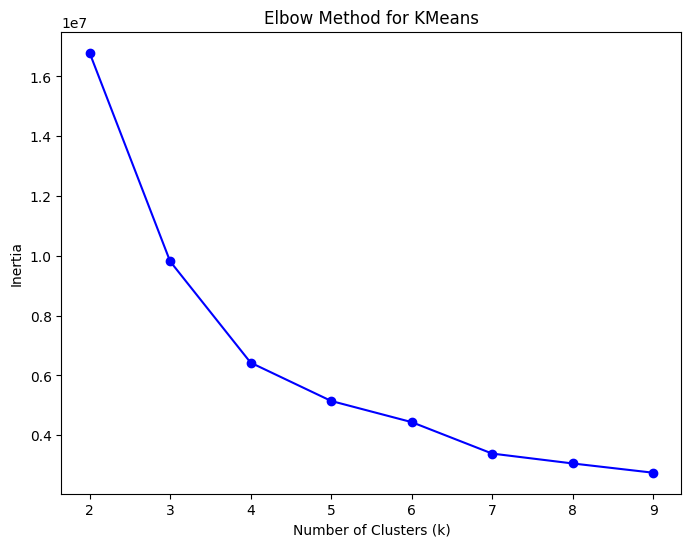

In [21]:
# Step 1: Assemble the features
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="unscaled_features")
new_training_data = assembler.transform(new_training_data)

# Step 2: Scale the features
scaler = StandardScaler(inputCol="unscaled_features", outputCol="RFM_scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(new_training_data)
new_training_data = scaler_model.transform(new_training_data)

# Step 3: Try KMeans with different values of k and track the inertia (cost)
inertias = []
k_values = range(2, 10)  # Trying k from 2 to 10

for k in k_values:
    print(f"value of k: {k}")
    kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="prediction")
    model = kmeans.fit(new_training_data)
    inertias.append(model.summary.trainingCost)

# Step 4: Plot the inertia values for different k
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [22]:
# Step 1: Fit the KMeans model with k=4
k = 4
kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="RFM_user_cluster")
model = kmeans.fit(new_training_data)

# Step 2: Assign clusters to the data
new_training_data = model.transform(new_training_data)

new_training_data = new_training_data.drop("Recency", "Frequency", "Monetary", "unscaled_features")


+------------------+---------+----------------+----------+
|           Recency|Frequency|        Monetary|prediction|
+------------------+---------+----------------+----------+
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
|151.99606481481482|        0|             0.0|         1|
| 99.37946759259259|        1|6.78000020980835|         1|
| 99.37946759259259|        1|6.78000020980835|         1|
| 99.37946759259259|        1|6.78000020980835|         

In [23]:
# Calculate average RFM values per cluster
new_training_data.groupBy("RFM_user_cluster").agg(
    F.avg("Recency").alias("Avg_Recency"),
    F.avg("Frequency").alias("Avg_Frequency"),
    F.avg("Monetary").alias("Avg_Monetary")
).show()


+----------+------------------+------------------+------------------+
|prediction|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|
+----------+------------------+------------------+------------------+
|         1|148.19794893547234| 1.792934851601373| 7.466444243106351|
|         3| 61.99256730839516|  82.9240754028762|370.12719936377084|
|         2| 44.79629907663455|269.01196210236594|1582.3865961717604|
|         0| 66.15238782661504|19.379407311269738| 81.59934421058372|
+----------+------------------+------------------+------------------+



* Cluster 1 (new customers) :  These customers are not recent(which could be as a result of no purchase considering how we handled the missing values in recnecy column), purchase very infrequently, and spend very little. 

* Cluster 3 (loyal customers) : These customers buy frequently, are fairly recent, and spend good amount of money.

* Cluster 2 (high value customers) : These customers are recent, buy extremely frequently, and have very high spending.

* Cluster 0 (potential loyalist) : These customers have moderate purchase frequently, are not very recent, and have moderate spending.

In [24]:
new_training_data.show()

+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+---------+----------------+--------------------+--------------------+----------+
|  user_id|         event_time|event_type|product_id|        category_id|     brand|price|        user_session|is_brand_missing|           Recency|Frequency|        Monetary|   unscaled_features|            features|prediction|
+---------+-------------------+----------+----------+-------------------+----------+-----+--------------------+----------------+------------------+---------+----------------+--------------------+--------------------+----------+
|108242662|2019-11-20 07:32:25|      view|   5800022|1487580005385896804|   UNKNOWN| 4.33|7ae492f2-5c12-4dd...|               1|151.99606481481482|        0|             0.0|[151.996064814814...|[0.75660975826449...|         1|
|108242662|2019-11-20 07:34:23|      view|   5800059|1487580005385896804|   UNKNOWN| 7.2

In [22]:
# purchases made in the last 2 days

train_purchase = new_training_data.filter(new_training_data['event_type'] == 'purchase')

train_purchase_per_2day = train_purchase.withColumn('two_day_purchase', 
                                                             F.from_unixtime(
                                                                 F.floor(F.unix_timestamp(F.col('event_time')) / (2 * 86400))* (2 * 86400) 
                                                                 )
                                                             )

train_purchase_per_2day = train_purchase_per_2day.groupBy('user_id','two_day_purchase').agg(F.count('*').alias('Num_purchase_per_2day'))
train_purchase_per_2day = train_purchase_per_2day.withColumnRenamed("user_id", "train_user_id") # rename 'user_id to prevent ambitiuity

train_purchase_per_2day.show()

+-------------+-------------------+---------------------+
|train_user_id|   two_day_purchase|Num_purchase_per_2day|
+-------------+-------------------+---------------------+
|    204490508|2019-11-22 01:00:00|                    2|
|    206869261|2019-11-28 01:00:00|                   20|
|    209554035|2019-10-21 01:00:00|                    5|
|    219542972|2019-11-02 01:00:00|                    7|
|    238282600|2019-11-08 01:00:00|                   27|
|    250576826|2019-10-07 01:00:00|                    1|
|    250576826|2019-10-09 01:00:00|                    2|
|    250576826|2019-11-18 01:00:00|                    4|
|    250576826|2019-11-20 01:00:00|                    5|
|    250576826|2020-01-21 01:00:00|                    4|
|    255936760|2019-10-13 01:00:00|                   12|
|    258322598|2019-10-01 01:00:00|                    6|
|    259672011|2019-11-28 01:00:00|                    3|
|    259914600|2019-11-22 01:00:00|                    1|
|    259965315

In [23]:
# Rename user_id in train_purchase_per_2day to avoid duplication in final result
train_purchase_per_2day = train_purchase_per_2day.withColumnRenamed("user_id", "train_user_id")

new_training_data = new_training_data.join(
    train_purchase_per_2day,
    (new_training_data['user_id'] == train_purchase_per_2day['train_user_id']) & 
    (F.floor(F.unix_timestamp(new_training_data['event_time']) / (2*86400)) ==  F.floor(F.unix_timestamp(train_purchase_per_2day['two_day_purchase']) / (2 * 86400))),
    how='left'
).drop('two_day_purchase','train_user_id').na.fill({'Num_purchase_per_2day' : 0 })



In [24]:
# average purchase price 

avg_purchase_price = train_purchase.groupBy('user_id').agg(F.format_number(F.mean('price'),2).cast(FloatType()).alias('Avg_purchase_price'))
avg_purchase_price = avg_purchase_price.withColumnRenamed("user_id", "train_user_id")

avg_purchase_price.show()

new_training_data = new_training_data.join(
    avg_purchase_price,
    new_training_data['user_id'] == avg_purchase_price['train_user_id'],
    how='left'
).drop('train_user_id').na.fill({'Avg_purchase_price' : 0})



+-------------+------------------+
|train_user_id|Avg_purchase_price|
+-------------+------------------+
|    204490508|              8.19|
|    206869261|              1.71|
|    209554035|              7.17|
|    219542972|              3.76|
|    238282600|              1.88|
|    250576826|              8.43|
|    255936760|              4.21|
|    258322598|              6.77|
|    259672011|             12.28|
|    259914600|              3.41|
|    259965315|             22.49|
|    291857238|              3.53|
|    298466411|              7.66|
|    305101297|              5.62|
|    306188225|              4.89|
|    308527782|             16.03|
|    311999365|              3.03|
|    313585738|               3.9|
|    315455483|              2.79|
|    327928030|              9.18|
+-------------+------------------+
only showing top 20 rows



In [25]:
new_training_data.count()

14455316

In [26]:
# most purchase category of user 

# groupby user id and brand and create a window specification to get the top three brands
brand_count = train_purchase.groupBy('user_id','brand').agg(F.count('brand').alias('brand_count'))

window_spec = Window.partitionBy('User_id').orderBy(F.desc('brand_count'))
ranked_brands = brand_count.withColumn('rank' ,F.row_number().over(window_spec))
top_brands = ranked_brands.filter(F.col("rank") <= 3)

top_brands = top_brands.groupBy("user_id").pivot("rank", [1, 2, 3]).agg(F.first("brand"))

# rename the columns
top_brands = top_brands.select(
    F.col("user_id"),
    F.col("1").alias("1_most_purchased_brand"),
    F.col("2").alias("2_most_purchased_brand"),
    F.col("3").alias("3_most_purchased_brand")
)

# Get the most purchased brand for each user
most_purchased_brand = brand_count.withColumn('rank', F.row_number().over(Window.partitionBy('user_id').orderBy(F.desc('brand_count'))))
most_purchased_brand = most_purchased_brand.filter(F.col('rank') == 1).select('user_id', 'brand')

# Join the top brands with the most purchased brand
top_brands_with_most_purchased = top_brands.join(most_purchased_brand, on='user_id', how='left')
top_brands_with_most_purchased = top_brands_with_most_purchased.withColumnsRenamed({'user_id':'train_user_id','brand':'preferred_brand'})
# Fill missing values with the user's most purchased brand
# Replace missing values with the preferred brand
top_brands_with_most_purchased = top_brands_with_most_purchased.withColumn(
    '1_most_purchased_brand',
    F.when(F.col('1_most_purchased_brand').isNull(), F.col('preferred_brand')).otherwise(F.col('1_most_purchased_brand'))
).withColumn(
    '2_most_purchased_brand',
    F.when(F.col('2_most_purchased_brand').isNull(), F.col('preferred_brand')).otherwise(F.col('2_most_purchased_brand'))
).withColumn(
    '3_most_purchased_brand',
    F.when(F.col('3_most_purchased_brand').isNull(), F.col('preferred_brand')).otherwise(F.col('3_most_purchased_brand'))
)



top_brands_with_most_purchased.show()

new_training_data = new_training_data.join(
    top_brands_with_most_purchased,
    new_training_data['user_id'] == top_brands_with_most_purchased['train_user_id'],
    how = 'left'
).drop('train_user_id','preferred_brand').na.fill({'1_most_purchased_brand':'UNKNOWN',
                                                   '2_most_purchased_brand':'UNKNOWN',
                                                   '3_most_purchased_brand' : 'UNKNOWN'})



+-------------+----------------------+----------------------+----------------------+---------------+
|train_user_id|1_most_purchased_brand|2_most_purchased_brand|3_most_purchased_brand|preferred_brand|
+-------------+----------------------+----------------------+----------------------+---------------+
|    204490508|                  rosi|                   uno|                  rosi|           rosi|
|    206869261|               UNKNOWN|             bpw.style|                runail|        UNKNOWN|
|    209554035|               UNKNOWN|               lianail|                  yoko|        UNKNOWN|
|    219542972|                de.lux|               UNKNOWN|                 irisk|         de.lux|
|    238282600|             bpw.style|               UNKNOWN|                  milv|      bpw.style|
|    250576826|               concept|                  oniq|               UNKNOWN|        concept|
|    255936760|               UNKNOWN|               levrana|              severina|       

In [13]:
# Total number of purchases by a user
train_purchase = new_training_data.filter(new_training_data['event_type'] == 'purchase')
total_purchases_by_user = train_purchase.groupBy('user_id').agg(F.count('event_type').alias('total_purchases_by_user'))

total_purchases_by_user.show()

new_training_data = new_training_data.join(
    total_purchases_by_user,
    on='user_id',
    how ='left'
).na.fill({'total_purchases_by_user':0})


+---------+-----------------------+
|  user_id|total_purchases_by_user|
+---------+-----------------------+
|204490508|                      1|
|206869261|                     15|
|209554035|                      5|
|219542972|                      7|
|238282600|                     27|
|250576826|                     13|
|255936760|                     12|
|258322598|                      6|
|259672011|                      1|
|259965315|                      6|
|291857238|                      2|
|298466411|                     11|
|305101297|                      4|
|306188225|                      5|
|308527782|                      1|
|311999365|                     16|
|313585738|                     33|
|315455483|                      1|
|327928030|                     10|
|331620050|                     12|
+---------+-----------------------+
only showing top 20 rows



In [14]:
# Total number of products purchased
total_purchases_by_user_across_items = train_purchase.groupBy('user_id').agg(
    F.countDistinct('product_id').alias('total_purchases_by_user_across_items'))



total_purchases_by_user_across_items.show()

new_training_data = new_training_data.join(
    total_purchases_by_user_across_items,
    on='user_id',
    how='left'
).na.fill({'total_purchases_by_user_across_items':0})


+---------+------------------------------------+
|  user_id|total_purchases_by_user_across_items|
+---------+------------------------------------+
|204490508|                                   1|
|206869261|                                  15|
|209554035|                                   5|
|219542972|                                   7|
|238282600|                                  27|
|250576826|                                   7|
|255936760|                                  12|
|258322598|                                   6|
|259672011|                                   1|
|259965315|                                   6|
|291857238|                                   2|
|298466411|                                  11|
|305101297|                                   4|
|306188225|                                   5|
|308527782|                                   1|
|311999365|                                  16|
|313585738|                                  32|
|315455483|         

In [ ]:
view_df = new_training_data.filter(F.col("event_type") == "view")

view_time = view_df.groupBy('user_id','product_id').agg(F.min('event_time').alias('view_time')).cache()
view_time.show()

purchase_time = train_purchase.groupBy('user_id','product_id').agg(F.min('event_time').alias('purchase_time'))

# Join views and purchases on user_id and product_id
time_diff_df = view_time.join(purchase_time, ["user_id", "product_id"], "inner")

time_diff_df.show()

# Calculate time difference between view and purchase
time_diff_df = time_diff_df.withColumn(
    "view_to_purchase_time", ((F.col("purchase_time").cast('long')) - (F.col("view_time").cast('long')))/86400
                              )


# Show result
time_diff_df = time_diff_df.select("user_id", "product_id", "view_to_purchase_time")




+---------+----------+-------------------+
|  user_id|product_id|          view_time|
+---------+----------+-------------------+
|108242662|   5800022|2019-11-20 07:32:25|
|108242662|   5800059|2019-11-20 07:34:23|
|108242662|   5896418|2020-01-28 06:23:09|
|108242662|   5896420|2020-01-28 06:24:17|
|108242662|   5856186|2020-01-28 06:25:26|
|108242662|   5563778|2020-01-28 06:28:28|
|108242662|   5892546|2020-01-28 06:30:40|
|108242662|   5683595|2020-01-28 06:31:25|
|204490508|   5878148|2019-11-22 15:05:36|
|204490508|   5869136|2019-11-22 15:06:21|
|204490508|   5815730|2019-11-22 15:23:30|
|204490508|   5599264|2019-11-22 15:25:41|
|204490508|   5780830|2019-11-22 15:26:56|
|206869261|   5836843|2019-11-19 12:03:35|
|206869261|   5890938|2019-11-19 12:07:53|
|206869261|   5695950|2019-11-19 12:12:41|
|206869261|   5695951|2019-11-19 12:12:44|
|206869261|   5809910|2019-11-29 07:26:47|
|206869261|   5805493|2019-11-29 07:33:24|
|206869261|   5808313|2019-11-29 07:33:38|
+---------+

### session based features 

In [27]:
# duration of users session

session_duration = new_training_data.groupBy('user_id','user_session').agg(
    F.min(F.col('event_time')).alias('session_start'),
    F.max(F.col('event_time')).alias('session_end')
).withColumn('session_duration', F.unix_timestamp('session_end') - F.unix_timestamp('session_start'))


session_duration.show()

# combine 

new_training_data = new_training_data.join(
    session_duration,
    on = ['user_id','user_session'],
    how='left'

).drop('session_start','session_end')

+---------+--------------------+-------------------+-------------------+----------------+
|  user_id|        user_session|      session_start|        session_end|session_duration|
+---------+--------------------+-------------------+-------------------+----------------+
|108242662|2eb8f823-8c17-42f...|2019-11-19 21:21:07|2019-11-19 21:21:07|               0|
|108242662|7ae492f2-5c12-4dd...|2019-11-20 07:32:25|2019-11-20 07:34:23|             118|
|108242662|ae67a3e7-8fb7-444...|2020-01-28 06:23:09|2020-01-28 06:35:38|             749|
|122831535|a3f4f697-10d6-44b...|2019-11-02 14:26:35|2019-11-02 14:26:35|               0|
|122831535|caf6915c-cb1e-4e8...|2019-11-08 10:16:40|2019-11-08 10:16:40|               0|
|122831535|55f3b439-b3a6-434...|2019-11-14 17:02:04|2019-11-14 17:02:04|               0|
|122831535|73b254f9-c653-4d2...|2019-11-14 17:02:12|2019-11-14 17:02:12|               0|
|122831535|e84d76f2-d5fc-440...|2020-01-13 19:07:09|2020-01-13 19:07:09|               0|
|122831535

In [29]:
# avearge session price for view,cart and purchase



session_avg_price = new_training_data.groupBy('user_id','user_session').agg(F.round(F.mean('price'),2).alias('Avg_session_prices'))

session_avg_price.show()

new_training_data = new_training_data.join(
    session_avg_price,
    on = ['user_id','user_session'],
    how='left'
).na.fill({'Avg_session_prices':0})

+---------+--------------------+------------------+
|  user_id|        user_session|Avg_session_prices|
+---------+--------------------+------------------+
|108242662|2eb8f823-8c17-42f...|             18.89|
|206869261|bcce3ddd-e7fb-413...|              1.83|
|209554035|c8273f41-1c4a-4c5...|               7.5|
|216129711|9486c445-163a-b17...|               7.4|
|216129711|6aa1d950-aa58-b89...|              8.05|
|219542972|9e79fce8-b466-4c6...|              1.03|
|219542972|c1b65a23-755a-4d5...|              0.66|
|219542972|de7d3833-856d-43a...|             18.73|
|230858777|11d45787-f6bb-40e...|              2.57|
|230858777|cf690fc8-7f12-494...|              2.74|
|230858777|133b9d2d-782d-489...|              3.56|
|230858777|026ee196-858b-4c4...|              0.32|
|230858777|96bc8a61-3665-47f...|              2.26|
|230858777|8de88e43-6f35-4e0...|               2.5|
|231688106|fcab8fd5-ba8d-4f0...|             21.43|
|238282600|399b29de-f69b-4dd...|              2.49|
|238282600|3

In [30]:
# total number of product viewed during a session

session_view = new_training_data.filter(F.col('event_type') == 'view')
num_session_view = session_view.groupBy('user_id','user_session').agg(F.count('event_type').alias('num_session_views'))

num_session_view.show()

# combine dataframe

new_training_data = new_training_data.join(
    num_session_view,
    on = ['user_id','user_session'],
    how='left'
).na.fill({'num_session_views' : 0})




+---------+--------------------+-----------------+
|  user_id|        user_session|num_session_views|
+---------+--------------------+-----------------+
|108242662|ae67a3e7-8fb7-444...|                7|
|108242662|7ae492f2-5c12-4dd...|                2|
|122831535|caf6915c-cb1e-4e8...|                1|
|122831535|cb203f05-c179-4d6...|                1|
|122831535|55f3b439-b3a6-434...|                1|
|122831535|73b254f9-c653-4d2...|                1|
|122831535|a3f4f697-10d6-44b...|                1|
|122831535|e84d76f2-d5fc-440...|                1|
|160496686|bcf0a5da-72f8-4cd...|                3|
|204490508|0b89bcc2-83f9-45f...|                5|
|206869261|bcce3ddd-e7fb-413...|               19|
|209554035|a97f6997-44aa-436...|                4|
|209554035|33528c5a-a6a7-4c7...|                1|
|209554035|c8273f41-1c4a-4c5...|                3|
|216129711|9486c445-163a-b17...|               37|
|216129711|c762de2b-3802-413...|                2|
|219542972|b749c88a-5dc5-4d7...

In [31]:
# number of product added ti cart in a sesiion

session_cart = new_training_data.filter(F.col('event_type') == 'cart')
num_session_cart = session_cart.groupBy('user_id','user_session').agg(F.count('event_type').alias('num_session_cart'))

num_session_cart.show()

# combine dataframe

new_training_data = new_training_data.join(
    num_session_cart,
    on = ['user_id','user_session'],
    how='left'
).na.fill({'num_session_cart' : 0})



+---------+--------------------+----------------+
|  user_id|        user_session|num_session_cart|
+---------+--------------------+----------------+
|108242662|ae67a3e7-8fb7-444...|               3|
|160496686|bcf0a5da-72f8-4cd...|               1|
|204490508|0b89bcc2-83f9-45f...|               5|
|206869261|bcce3ddd-e7fb-413...|              40|
|209554035|a97f6997-44aa-436...|              11|
|209554035|c8273f41-1c4a-4c5...|               4|
|216129711|9486c445-163a-b17...|              42|
|219542972|c1b65a23-755a-4d5...|               5|
|219542972|5707f90b-5370-445...|               1|
|219542972|3fd4993c-8619-4b7...|               2|
|219542972|9e79fce8-b466-4c6...|               7|
|219542972|de7d3833-856d-43a...|               1|
|230858777|11d45787-f6bb-40e...|               2|
|230858777|cf690fc8-7f12-494...|               1|
|230858777|6fb18bf6-7a8d-471...|               1|
|230858777|133b9d2d-782d-489...|              27|
|230858777|026ee196-858b-4c4...|              28|


In [33]:
# session purchase


session_purchase = new_training_data.filter(F.col('event_type') == 'purchase')
num_session_purchase = session_purchase.groupBy('user_id', 'user_session').agg(F.count('event_type').alias('num_session_purchase'))

new_training_data = new_training_data.join(
    num_session_purchase,
    on=['user_id', 'user_session'],
    how='left'
).na.fill({'num_session_purchase':0})




In [34]:
# cart-to-purchase ration


new_training_data = new_training_data.withColumn('session_cart_to_purchase_ratio', F.when(F.col('num_session_purchase') == 0 , 0).otherwise(
    F.col('num_session_cart') / F.col('num_session_purchase')
))

new_training_data = new_training_data.withColumn('session_cart_to_purchase_ratio', F.round(F.col('session_cart_to_purchase_ratio'), 2))


In [35]:

# Calculate Cart Abandonment Rate and round to two decimal points
new_training_data = new_training_data.withColumn('session_cart_abandonment_rate', 
                           F.when(F.col('num_session_cart') == 0, 0)  # Handle case where no products were added to the cart
                           .otherwise(1 - (F.col('num_session_purchase') / F.col('num_session_cart'))))

new_training_data = new_training_data.withColumn('session_cart_abandonment_rate', F.round(F.col('session_cart_abandonment_rate'), 2)).persist(StorageLevel.DISK_ONLY)



### Product features 

In [60]:
product_purchase = train_purchase.groupBy('product_id').agg(
    F.count('product_id').alias('total_num_product_purchased')
)


product_purchase.show()

new_training_data = new_training_data.join(
    product_purchase,
    on=['product_id'],
    how='left'
).na.fill({'total_num_product_purchased':0})



+----------+---------------------+
|product_id|num_product_purchased|
+----------+---------------------+
|   5833322|                  395|
|      5925|                   19|
|   5760785|                   79|
|   5809268|                   70|
|      6731|                  152|
|   5700501|                   81|
|   5724653|                   19|
|   5859440|                   59|
|   5677989|                   94|
|     15269|                    7|
|   5800056|                    6|
|   5697109|                   11|
|   5704999|                   63|
|   5883314|                  254|
|   5875362|                  166|
|   5699223|                   34|
|   5758067|                    6|
|   5783557|                   18|
|   5690569|                   13|
|   5727771|                    4|
+----------+---------------------+
only showing top 20 rows



In [61]:
new_training_data.show()

+----------+-------------------+----------------+-------------------+-------+-----+---------+--------------------+----------------+---------------------+
|product_id|         event_time|      event_type|        category_id|  brand|price|  user_id|        user_session|is_brand_missing|num_product_purchased|
+----------+-------------------+----------------+-------------------+-------+-----+---------+--------------------+----------------+---------------------+
|   5804167|2019-10-01 04:53:45|            cart|1487580005671109489| masura| 1.73|468353545|e85c79e0-3882-42d...|               0|                   30|
|   5610054|2019-10-01 05:46:31|            cart|1487580006551913373|   milv| 2.38|483832589|c294e056-2610-4fb...|               0|                   28|
|   5853713|2019-10-01 03:57:41|remove_from_cart|1487580009286598681| runail| 2.06|386491215|34179930-7376-48e...|               0|                  426|
|   5706784|2019-10-01 03:19:17|            cart|1487580005092295511| runail

In [63]:
null_count = new_training_data.filter(F.col('num_product_purchased').isNull()).count()
print(f"Number of nulls in 'num_product_purchased': {null_count}")


Number of nulls in 'num_product_purchased': 219788


In [64]:
# total number of product views

train_views = new_training_data.filter(F.col('event_type') == 'view')

# groupby by product
product_views = train_views.groupBy('product_id').agg(F.count('product_id').alias('total_product_views'))

product_views.show()

new_training_data = new_training_data.join(
    product_views,
    on = ['product_id'],
    how='left'
).na.fill({'total_product_views':0})



+----------+-------------------+
|product_id|total_product_views|
+----------+-------------------+
|   5886193|                 95|
|   5752486|                 41|
|   5760785|                374|
|   5618278|                154|
|   5667106|                 13|
|   5804345|                 33|
|   5877723|                 34|
|   5809268|                186|
|   5852507|                313|
|   5706454|                 55|
|   5712736|                526|
|   5813329|                 66|
|   5692484|                 29|
|   5699223|                117|
|   5884241|                 60|
|   5857316|                 46|
|   5835374|                 51|
|   5700214|                 44|
|   5837465|                309|
|   5869132|                554|
+----------+-------------------+
only showing top 20 rows



In [65]:
new_training_data.show()

+----------+-------------------+----------------+-------------------+-------+-----+---------+--------------------+----------------+---------------------+-------------------+
|product_id|         event_time|      event_type|        category_id|  brand|price|  user_id|        user_session|is_brand_missing|num_product_purchased|total_product_views|
+----------+-------------------+----------------+-------------------+-------+-----+---------+--------------------+----------------+---------------------+-------------------+
|   5804167|2019-10-01 04:53:45|            cart|1487580005671109489| masura| 1.73|468353545|e85c79e0-3882-42d...|               0|                   30|                107|
|   5610054|2019-10-01 05:46:31|            cart|1487580006551913373|   milv| 2.38|483832589|c294e056-2610-4fb...|               0|                   28|                184|
|   5853713|2019-10-01 03:57:41|remove_from_cart|1487580009286598681| runail| 2.06|386491215|34179930-7376-48e...|               0

In [66]:
# total product add to cart

train_cart = new_training_data.filter(F.col('event_type') == 'cart')

product_cart = train_cart.groupBy('product_id').agg(F.count('product_id').alias('total_product_cart'))

product_cart.show()

new_training_data = new_training_data.join(
    product_cart,
    on=['product_id'],
    how='left'
).na.fill({'total_product_cart':0})



+----------+------------------+
|product_id|total_product_cart|
+----------+------------------+
|   5773322|                42|
|   5563794|                54|
|   5848791|                 8|
|   5782947|                18|
|   5813912|                29|
|      6731|               500|
|   5875374|               181|
|   5854189|                16|
|   5819241|               210|
|   5784566|                46|
|   5794153|               260|
|   5875362|               657|
|   5833322|              1280|
|   5803877|                35|
|   5746402|               111|
|   5801756|                24|
|   5778722|                85|
|   5773340|               120|
|   5760785|               328|
|   5697109|                56|
+----------+------------------+
only showing top 20 rows



In [67]:
new_training_data.show()

+----------+-------------------+----------------+-------------------+-------+-----+---------+--------------------+----------------+---------------------+-------------------+------------------+
|product_id|         event_time|      event_type|        category_id|  brand|price|  user_id|        user_session|is_brand_missing|num_product_purchased|total_product_views|total_product_cart|
+----------+-------------------+----------------+-------------------+-------+-----+---------+--------------------+----------------+---------------------+-------------------+------------------+
|   5804167|2019-10-01 04:53:45|            cart|1487580005671109489| masura| 1.73|468353545|e85c79e0-3882-42d...|               0|                   30|                107|               144|
|   5610054|2019-10-01 05:46:31|            cart|1487580006551913373|   milv| 2.38|483832589|c294e056-2610-4fb...|               0|                   28|                184|               135|
|   5853713|2019-10-01 03:57:41|rem

In [70]:
# product cart  purchase conversion rate 


new_training_data = new_training_data.withColumn('product_cart_to_purchase_conversion_ratio', F.when(F.col('total_num_product_purchased') == 0 , 0).otherwise(
    F.col('total_product_cart') / F.col('total_num_product_purchased')
))

new_training_data = new_training_data.withColumn('product_cart_to_purchase_conversion_ratio', F.round(F.col('product_cart_to_purchase_conversion_ratio'), 2)).persist(StorageLevel.DISK_ONLY)

new_training_data.show()

+----------+-------------------+----------------+-------------------+-----------+-----+---------+--------------------+----------------+---------------------+-------------------+------------------+-----------------------------------------+
|product_id|         event_time|      event_type|        category_id|      brand|price|  user_id|        user_session|is_brand_missing|num_product_purchased|total_product_views|total_product_cart|product_cart_to_purchase_conversion_ratio|
+----------+-------------------+----------------+-------------------+-----------+-----+---------+--------------------+----------------+---------------------+-------------------+------------------+-----------------------------------------+
|   5886193|2019-10-01 08:33:52|            view|1487580013690618064|     consly| 5.87|541909826|01b9fb74-8c2b-4d2...|               0|                   10|                 95|                49|                                      4.9|
|   5833322|2019-10-05 07:19:55|        purc

### user - product interaction 

In [71]:
#user_product_view_count

user_product_view = train_views.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_view'))

user_product_view.show()

new_training_data = new_training_data.join(
    user_product_view,
    on=['user_id','product_id'],
    how='left'
).na.fill({'user_product_view':0})



+---------+----------+-----------------+
|  user_id|product_id|user_product_view|
+---------+----------+-----------------+
|542357047|   5852517|                1|
|515443537|   5687741|                1|
|511173605|   5693593|                1|
|411113964|   5801325|                2|
|463842147|   5826406|                1|
|556310217|   5838846|                1|
|557324555|   5740986|                1|
|556551445|   5588152|                1|
|556350711|   5649236|                1|
|550883221|   5877454|                1|
|503093887|   5857069|                1|
|555256312|   5712790|                1|
|556164626|   5872904|                5|
|359124175|   5851621|                1|
|557711264|   5785424|                1|
|557698181|   5635103|                1|
|528635770|   5769914|                2|
|392937743|   5837620|                2|
|557520412|   5861557|                1|
|556127613|   5877454|                1|
+---------+----------+-----------------+
only showing top

In [72]:
#user_product_add to cart _count

user_product_cart = train_cart.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_cart'))

user_product_cart.show()

new_training_data = new_training_data.join(
    user_product_cart,
    on=['user_id','product_id'],
    how='left'
).na.fill({'user_product_cart':0})


+---------+----------+-----------------+
|  user_id|product_id|user_product_cart|
+---------+----------+-----------------+
|510669794|      5953|                1|
|555813359|   5853604|                3|
|540249915|   5758061|                1|
|556043509|   5843998|                3|
|555873806|   5687470|                3|
|557585105|   5856550|                2|
|379259878|   5788435|                2|
|557489316|   5859475|                2|
|555778305|   5747359|                3|
|402334206|   5815083|                1|
|486328391|   5563754|                1|
|549172882|   5886746|                1|
|547733654|   5751383|                1|
|506513604|   5622677|                1|
|554797493|   5812117|                1|
|557326643|   5848635|                3|
|551676584|   5695489|                1|
|556122109|   5870668|                3|
|557227863|   5878510|                3|
|480151395|   5760785|                1|
+---------+----------+-----------------+
only showing top

In [73]:
#user_product_ purcahse

user_product_purchase = train_purchase.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_purchase'))

user_product_purchase.show()

new_training_data = new_training_data.join(
    user_product_purchase,
    on=['user_id','product_id'],
    how='left'
).na.fill({'user_product_purchase':0}).persist(StorageLevel.DISK_ONLY)

new_training_data.show()

+---------+----------+---------------------+
|  user_id|product_id|user_product_purchase|
+---------+----------+---------------------+
|477118331|   5683947|                    1|
|539457086|      4915|                    1|
|538498612|   5749149|                    1|
|555790106|   5797977|                    1|
|555996661|   5860437|                    1|
|474393926|   5700167|                    1|
|480463194|   5873653|                    1|
|555150103|   5760770|                    1|
|525401126|   5688125|                    1|
|535820863|   5873171|                    1|
|469091951|   5549838|                    1|
|509653293|   5866156|                    1|
|557495972|   5808546|                    1|
|553959742|   5856193|                    1|
|467567265|   5744098|                    1|
|545647953|   5818396|                    1|
|555738287|   5866174|                    1|
|519108765|   5877609|                    1|
|531299903|   5843567|                    1|
|489992190

In [ ]:
# conversion rate from view to purchase
view_to_purchase_conversion_rate_for_item = new_training_data.withColumn('view_to_purchase_conversion_rate_for_item',
                                                                         F.col('user_product_purchase')/F.col('user_product_view'))



In [ ]:
# hour of the day

new_training_data = new_training_data.withColumn('hour',F.hour(F.col('event_time')))
new_training_data = new_training_data.withColumn('month',F.month(F.col('event_time')))
new_training_data  = new_training_data.withColumn('minutes',F.minute(F.col('event_time')))
new_training_data = new_training_data.withColumn('seconds',F.second(F.col('event_time')))

# add cyclic time features 
new_training_data = new_training_data.withColumn(
    'hour_sin' , F.sin(2 * math.pi * F.col('hour') / 24)
).withColumn('hour_cos',F.cos(2 * math.pi * F.col('hour') / 24))

new_training_data = new_training_data.withColumn(
    'minutes_sin' , F.sin(2 * math.pi * F.col('minutes') / 24)
).withColumn('minutes_cos',F.cos(2 * math.pi * F.col('minutes') / 24))

new_training_data = new_training_data.withColumn(
    'second_sin',F.sin(2 * math.pi * F.col('seconds') / 24)
).withColumn('second_cos',F.cos(2 * math.pi * F.col('seconds') / 24))


new_training_data = new_training_data.withColumn('week',F.dayofweek(F.col('event_time')))
new_training_data.drop('hour','minutes','seconds')

new_training_data.show()

+---------+----------+-------------------+----------+-------------------+--------+-----+--------------------+----------------+---------------------+-------------------+------------------+-----------------------------------------+-----------------+-----------------+---------------------+----+-------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+
|  user_id|product_id|         event_time|event_type|        category_id|   brand|price|        user_session|is_brand_missing|num_product_purchased|total_product_views|total_product_cart|product_cart_to_purchase_conversion_ratio|user_product_view|user_product_cart|user_product_purchase|hour|minutes|seconds|           hour_sin|            hour_cos|         minutes_sin|         minutes_cos|          second_sin|          second_cos|week|
+---------+----------+-------------------+----------+-------------------+--------+-----+--------------------+-------------

In [ ]:


# Define the features to be hashed
features_to_hash = ['user_id', 'product_id', 'category_id', 'brand', 'user_session','1_most_purchased_category','2_most_purchased_category',
                    '3_most_purchased_category']

# Create StringIndexers for categorical features


# Create HashingTF transformers
hashingTFs = [FeatureHasher(inputCols=[col], outputCol=f"{col}_hash", numFeatures=8000) for col in features_to_hash] 

# Assemble all hashed features into a single vector
assembler = VectorAssembler(inputCols=[f"{col}_hash" for col in features_to_hash], outputCol="Assembled_hashed_features")



# Create a pipeline to chain the transformations
#from pyspark.ml import Pipeline
#pipeline = Pipeline(stages= [string_indexers + hashingTFs + assembler])

# Fit and transform the data
#hashed_df = pipeline.fit(new_training_data).transform(new_training_data)

# Select the original columns and the hashed features
#selected_cols = [c for c in new_training_data.columns] + ["hashed_features"]
#hashed_df = hashed_df.select(*selected_cols)

# Show the resulting DataFrame
#hashed_df.show()

In [ ]:

# Step 1: Compute total interactions for each user
user_total_interactions = training_data.groupBy("user_id").agg(F.count("*").alias("total_interactions"))

# Step 2: Join the total interactions back to the original DataFrame
training_data = training_data.join(user_total_interactions, on="user_id")


# Step 3: Filter out users with less than or equal to 3 interactions
training_data = training_data.filter(training_data.total_interactions > 3)


user_window = Window.partitionBy("user_id").orderBy("event_time")
df_with_rank = training_data.withColumn("interaction_rank", F.row_number().over(user_window))


train_cutoff = 0.7  # 70% for training


df_with_rank = df_with_rank.withColumn(
    "is_train",
    F.when(
        (df_with_rank["interaction_rank"] <= (df_with_rank["total_interactions"] * train_cutoff)) | 
        (df_with_rank["total_interactions"] <= 2),  # Include customers with 1 interaction
        True
    ).otherwise(False)
)



train_df = df_with_rank.filter("is_train = true")
test_df = df_with_rank.filter("is_train = false")



In [ ]:
val_user_id = test_df.select('user_id').distinct()
train_user_id = train_df.select('user_id').distinct()

val_not_in_train = train_user_id.intersect(val_user_id)
print(f"Number of users in training in validation: {val_not_in_train.count()}")

## putting together 

In [3]:
@dataclass
class DataTransformationConfig:
    source_datapath : Path
    source_parquetpath :Path
    schema : dict
    featurestore_path : Path
    train_datapath : Path
    val_datapath : Path
    test_datapath : Path
    train_transformed_datapath : Path
    val_transformed_datapath : Path
    test_transformed_datapath : Path



class ConfigurationManager:
    def __init__(self,config=CONFIG_FILE_PATH,
                 params=PARAMS_FILE_PATH,
                 schema=SCHEMA_FILE_PATH):
        
        self.config = read_yaml(str(config))
        self.params = read_yaml(str(params))
        self.schema  = read_yaml(str(schema))

    def get_data_transformation_config(self) -> DataTransformationConfig:

        config = self.config.DATA_TRANSFORMATION
        schema = self.schema['schema']

        config_object = DataTransformationConfig(
            source_datapath=config.source_datapath,
            source_parquetpath = config.source_parquetpath,
            schema=schema,
            featurestore_path = config.feature_store_path,
            train_datapath = config.train_datapath,
            val_datapath = config.val_datapath,
            test_datapath = config.test_datapath,
            train_transformed_datapath = config.train_transformed_datapath,
            val_transformed_datapath = config.val_transformed_datapath,
            test_transformed_datapath = config.test_transformed_datapath
        )

        return config_object
    

class DataTransformation:

    def __init__(self,config = DataTransformationConfig):

        self.config = config
        self.spark = spark_session()

    def read_schema(self):

        fields = []

        logging.info('Reading schema from schema.yaml')
        logging.info(f'schema {self.config.schema}')

        for  field_dict in self.config.schema['fields']:
            field_type = getattr(types, field_dict['type'])()
            fields.append(StructField(field_dict['name'], field_type))

        return StructType(fields)
    
    def load_data(self):
        try:
            parquet_path = self.config.source_parquetpath  # Path for Parquet files
            
            # Check if the Parquet file exists
            if os.path.exists(parquet_path):
                logging.info(f'Parquet file exists, loading data from {parquet_path}')
                return parquet_path  # Return the path to the existing Parquet file
            else:
                # Load data from CSV if Parquet file is not available
                logging.info(f'Loading data from {self.config.source_datapath}')
                datapath = glob(self.config.source_datapath)  # List of CSV files
                self.schema = self.read_schema()  # Read or define the schema
                

                df = None
                for path in datapath:
                    logging.info(f'data path :{path}')
                    # Load each CSV file and combine them into a DataFrame
                    temp_df = self.spark.read.csv(path, schema=self.schema, header=True)
                    df = temp_df if df is None else df.union(temp_df)
                
                    logging.info(f'number of data point {df.count()}')

                # Order by event_time if needed
                df = df.orderBy('event_time')

                # Save the processed DataFrame to Parquet for future use
                logging.info(f'Saving processed data as Parquet at {parquet_path}')
                df.write.parquet(parquet_path,mode='overwrite')

                # Return the path to the newly saved Parquet file
                return parquet_path

        except Exception as e:
            logging.error(f'Could not load data: {e}')
            return None
        
    def train_val_test_split(self, data_path):
        logging.info('splitting data into training, validation and test split')
        try:
            """
            Splits the data into train, validation, and test sets based on user interactions and event time.

            Parameters:
            data (DataFrame): Input DataFrame with columns 'user_id', 'event_time', and other features.

            """

            data = self.spark.read.parquet(data_path)

            # remove remove from cart eventy type
            data = data.filter(data['event_type'] != 'remove_from_cart')
            

            #  Compute total interactions for each user
            user_total_interactions = data.groupBy("user_id").agg(F.count("*").alias("total_interactions"))

            #  Join the total interactions back to the original DataFrame
            data = data.join(user_total_interactions, on="user_id")

            # filter out interactions with less than 3 interactions
            data = data.filter(F.col('total_interactions') > 2)
            logging.info('filter out users with low interactions')

            # Assign interaction ranks within each user based on event_time
            user_window = Window.partitionBy("user_id").orderBy("event_time")
            df_with_rank = data.withColumn("interaction_rank", F.row_number().over(user_window))

            # Define split cutoffs
            train_cutoff = 0.7  # 70% for training
            val_cutoff = 0.85   # Next 15% for validation (leaving 10% for testing)

        
            df_with_rank = df_with_rank.withColumn(
                "split",
                F.when(
                    (df_with_rank["interaction_rank"] <= (df_with_rank["total_interactions"] * train_cutoff)) |
                    (df_with_rank["total_interactions"] <= 2),  # Include users with <= 2 interactions in training
                    "train"
                ).when(
                    (df_with_rank["interaction_rank"] > (df_with_rank["total_interactions"] * train_cutoff)) &
                    (df_with_rank["interaction_rank"] <= (df_with_rank["total_interactions"] * val_cutoff)),
                    "val"
                ).otherwise("test")
            )


            # Filter data into train, validation, and test DataFrames
            train_df = df_with_rank.filter("split = 'train'").drop("split",'total_interactions')
            val_df = df_with_rank.filter("split = 'val'").drop("split",'total_interactions')
            test_df = df_with_rank.filter("split = 'test'").drop("split",'total_interactions')
            logging.info('Data splitted into train,val nad test set')

            # save set into feature store
            train_path = self.config.train_datapath
            val_path = self.config.val_datapath
            test_path = self.config.test_datapath
            train_df.write.parquet(self.config.train_datapath,mode='overwrite')
            val_df.write.parquet(self.config.val_datapath,mode='overwrite')
            test_df.write.parquet(self.config.test_datapath,mode='overwrite')
            
            logging.info(f"Returning paths: {train_path}, {val_path}, {test_path}")
            return train_path,val_path,test_path

        except Exception as e :
            logging.error(f'Could not split data : {e}')

    def feature_engineering(self,data_path):

        try: 

            logging.info(f'Starting feature engineering ofr {data_path}')

            data = self.spark.read.parquet(data_path) # read data

            data = data.sample(fraction=0.001,seed=42)

            # handling the missing values
            data = data.drop('category_code')
            data = data.fillna({'brand':'UNKNOWN'})

            # Add the 'is_brand_missing' column to indicate if the brand is missing
            data = data.withColumn('is_brand_missing', F.when(F.col('brand') == 'UNKNOWN',F.lit(1)).otherwise(F.lit(0)))
            data = data.dropna(subset=['user_session'])

            # dropduplicates 
            data = data.dropDuplicates()

            data = data.withColumn('price',F.abs(data['price']))

            # purchases made in the last 2 days
            logging.info('creating features : two_day_purchase')
            train_purchase = data.filter(data['event_type'] == 'purchase')
            train_purchase_per_2day = train_purchase.withColumn('two_day_purchase', 
                                                                        F.from_unixtime(
                                                                            F.floor(F.unix_timestamp(F.col('event_time')) / (2 * 86400))* (2 * 86400) 
                                                                            )
                                                                        )
            train_purchase_per_2day = train_purchase_per_2day.groupBy('user_id','two_day_purchase').agg(F.count('*').alias('Num_purchase_per_2day'))
            train_purchase_per_2day = train_purchase_per_2day.withColumnRenamed("user_id", "train_user_id") # rename 'user_id to prevent ambitiuity
            # Rename user_id in train_purchase_per_2day to avoid duplication in final result
            train_purchase_per_2day = train_purchase_per_2day.withColumnRenamed("user_id", "train_user_id")
            data = data.join(
                train_purchase_per_2day,
                (data['user_id'] == train_purchase_per_2day['train_user_id']) & 
                (F.floor(F.unix_timestamp(data['event_time']) / (2*86400)) ==  F.floor(F.unix_timestamp(train_purchase_per_2day['two_day_purchase']) / (2 * 86400))),
                how='left'
            ).drop('two_day_purchase','train_user_id').na.fill({'Num_purchase_per_2day' : 0 })

            # creating RFM FEATURES
            # recency
            logging.info('creating feature : recency')
            reference_time = data.select(F.max(F.col('event_time')).cast('long')).collect()[0][0]
            last_purchase_time = train_purchase.groupBy('user_id').agg(F.max('event_time').alias('last_purchase_time'))
            recency_df = last_purchase_time.withColumn('Recency', (F.lit(reference_time) - F.col('last_purchase_time').cast('long'))/86400).drop('last_purchase_time') # calculate rency and convert to days

            data = data.join(
                recency_df ,
                on = 'user_id',
                how = 'left'
            )
            # fill missing values
            min_event_time = data.select(F.min('event_time')).collect()[0][0]
            max_recency_value = (reference_time - min_event_time.timestamp()) / 86400  # Convert to days
            # Fill missing Recency values with the calculated scalar max_recency_value
            data = data.na.fill({'Recency': max_recency_value})

            # frequency
            logging.info('creating feature : frequency')
            frequency_df = train_purchase.groupBy('user_id').agg(F.count(F.col('event_type')).alias('Frequency'))

            data = data.join(
                frequency_df,
                on='user_id',
                how='left'
            ).na.fill({'Frequency':0})

            logging.info('creating feature : monetary value')
            monetary_value = train_purchase.groupBy('user_id') \
                        .agg(F.sum(F.col('price')).alias('Monetary'))

            data = data.join(
                monetary_value,
                on='user_id',
                how='left'
            ).na.fill({'Monetary':0})


            # average purchase price 
            logging.info('creating feature : Avg_purchase_price')
            avg_purchase_price = train_purchase.groupBy('user_id').agg(F.format_number(F.mean('price'),2).cast(FloatType()).alias('Avg_purchase_price'))
            avg_purchase_price = avg_purchase_price.withColumnRenamed("user_id", "train_user_id")
            data = data.join(
                avg_purchase_price,
                data['user_id'] == avg_purchase_price['train_user_id'],
                how='left'
            ).drop('train_user_id').na.fill({'Avg_purchase_price' : 0})
            logging.info('combined feature(Avg__purchase_price) to main dataframe')


            # normalized price
            logging.info('creating feature : normalised_product_price')
            window_cat = Window.partitionBy('category_id')
            data = data.withColumn('avg_cat_price',F.avg('price').over(window_cat))
            data = data.withColumn('normalised_price',F.col('price')/F.col('avg_cat_price')).drop('avg_cat_price')



            # most purchase category of user 
            # groupby user id and category and create a window specification to get the top three brands
            logging.info('creating most purchase category')
            category_count = train_purchase.groupBy('user_id','category_id').agg(F.count('category_id').alias('category_count'))
            window_spec = Window.partitionBy('User_id').orderBy(F.desc('category_count'))
            ranked_categorys = category_count.withColumn('rank' ,F.row_number().over(window_spec))
            top_categorys = ranked_categorys.filter(F.col("rank") <= 3)

            top_categorys = top_categorys.groupBy("user_id").pivot("rank", [1, 2, 3]).agg(F.first("category_id"))
            # rename the columns
            top_brands = top_categorys.select(
                F.col("user_id"),
                F.col("1").alias("1_most_purchased_category"),
                F.col("2").alias("2_most_purchased_category"),
                F.col("3").alias("3_most_purchased_category")
            )
            # Get the most purchased brand for each user
            most_purchased_category = category_count.withColumn('rank', F.row_number().over(Window.partitionBy('user_id').orderBy(F.desc('category_count'))))
            most_purchased_category = most_purchased_category.filter(F.col('rank') == 1).select('user_id', 'category_id')

            # Join the top brands with the most purchased brand
            top_category_with_most_purchased = top_brands.join(most_purchased_category, on='user_id', how='left')
            top_category_with_most_purchased = top_category_with_most_purchased.withColumnsRenamed({'user_id':'train_user_id','category_id':'preferred_category'})
            # Fill missing values with the user's most purchased brand
            # Replace missing values with the preferred brand
            top_brands_with_most_purchased = top_category_with_most_purchased.withColumn(
                '1_most_purchased_category',
                F.when(F.col('1_most_purchased_category').isNull(), F.col('preferred_category')).otherwise(F.col('1_most_purchased_category'))
            ).withColumn(
                '2_most_purchased_category',
                F.when(F.col('2_most_purchased_category').isNull(), F.col('preferred_category')).otherwise(F.col('2_most_purchased_category'))
            ).withColumn(
                '3_most_purchased_category',
                F.when(F.col('3_most_purchased_category').isNull(), F.col('preferred_category')).otherwise(F.col('3_most_purchased_category'))
            )

            data = data.join(
                top_brands_with_most_purchased,
                data['user_id'] == top_brands_with_most_purchased['train_user_id'],
                how = 'left'
            ).drop('train_user_id','preferred_category').na.fill({'1_most_purchased_category':'No purchase',
                                                            '2_most_purchased_category':'No purchase',
                                                            '3_most_purchased_category' : 'No purchase'})
            
            logging.info('combined feature(most _purchase_category) to main dataframe')


            # duration of users session
            logging.info('creating feature : user_session_duration')
            session_duration = data.groupBy('user_id','user_session').agg(
                F.min(F.col('event_time')).alias('session_start'),
                F.max(F.col('event_time')).alias('session_end')
            ).withColumn('session_duration', F.unix_timestamp('session_end') - F.unix_timestamp('session_start'))
            # combine 
            data = data.join(
                session_duration,
                on = ['user_id','user_session'],
                how='left'

            ).drop('session_start','session_end')
            logging.info('combined feature(user_session_duration) to main dataframe')

            # avearge session price for view,cart and purchase
            logging.info('creating feature : session_avg_intent_price')
            session_purchase_intent_price  = data.filter(F.col('event_type') == 'remove_from_cart')
            session_avg_price = session_purchase_intent_price.groupBy('user_id','user_session').agg(F.round(F.mean('price'),2).alias('Avg_session_intent_prices'))
            data = data.join(
                session_avg_price,
                on = ['user_id','user_session'],
                how='left'
            )

            # total number of product viewed during a session
            logging.info('creating feature : num_session_views')
            session_view = data.filter(F.col('event_type') == 'view')
            num_session_view = session_view.groupBy('user_id','user_session').agg(F.count('event_type').alias('num_session_views'))
            # combine dataframe
            data = data.join(
                num_session_view,
                on = ['user_id','user_session'],
                how='left'
            ).na.fill({'num_session_views' : 0})

            # number of product added to cart in a sesiion
            logging.info('creating feature : num_session_cart')
            session_cart = data.filter(F.col('event_type') == 'cart')
            num_session_cart = session_cart.groupBy('user_id','user_session').agg(F.count('event_type').alias('num_session_cart'))
            # combine dataframe
            data = data.join(
                num_session_cart,
                on = ['user_id','user_session'],
                how='left'
            ).na.fill({'num_session_cart' : 0})

            # number of produt removed from cart
            logging.info('creating feature : num_session_frm_cart')
            session_frm_cart = data.filter(F.col('event_type') == 'remove_from_cart')
            num_session_frm_cart = session_frm_cart.groupBy('user_id','user_session').agg(F.count('event_type').alias('num_session_frm_cart'))
            # combine dataframe
            data= data.join(
                num_session_frm_cart,
                on = ['user_id','user_session'],
                how='left'
            ).na.fill({'num_session_frm_cart' : 0})

            # session purchase
            logging.info('creating feature : num_session_purchase')
            session_purchase = data.filter(F.col('event_type') == 'purchase')
            num_session_purchase = session_purchase.groupBy('user_id', 'user_session').agg(F.count('event_type').alias('num_session_purchase'))
            data = data.join(
                num_session_purchase,
                on=['user_id', 'user_session'],
                how='left'
            ).na.fill({'num_session_purchase':0})

            # cart-to-purchase ration
            logging.info('creating feature : session_cart_to_purchase_ratio')
            data = data.withColumn('session_cart_to_purchase_ratio', F.when(F.col('num_session_purchase') == 0 , 0).otherwise(
                F.col('num_session_cart') / F.col('num_session_purchase')
            ))
            data = data.withColumn('session_cart_to_purchase_ratio', F.round(F.col('session_cart_to_purchase_ratio'), 2))

            # Calculate Cart Abandonment Rate and round to two decimal points
            logging.info('creating feature : session_cart_abondonment_rate')
            data = data.withColumn('session_cart_abandonment_rate', 
                                    F.when(F.col('num_session_cart') == 0, 0)  # Handle case where no products were added to the cart
                                    .otherwise(1 - (F.col('num_session_purchase') / F.col('num_session_cart'))))

            data = data.withColumn('session_cart_abandonment_rate', F.round(F.col('session_cart_abandonment_rate'), 2))

            # total product purchased
            logging.info('creating feature : total_num_product_purchased')
            product_purchase = train_purchase.groupBy('product_id').agg(
                F.count('product_id').alias('total_num_product_purchased')
            )
            data = data.join(
                product_purchase,
                on=['product_id'],
                how='left'
            ).na.fill({'total_num_product_purchased':0})

            # total number of product views
            logging.info('creating feature : total_product_views')
            train_views = data.filter(F.col('event_type') == 'view')
            # groupby by product
            product_views = train_views.groupBy('product_id').agg(F.count('product_id').alias('total_product_views'))
            data = data.join(
                product_views,
                on = ['product_id'],
                how='left'
            ).na.fill({'total_product_views':0})

            #popularity percentile
            # Compute max view_count per category
            logging.info('createing feature : popularity percentile')
            data = data.withColumn(
                "max_view_category",
                F.max("total_product_views").over(window_cat)
            )
            # Compute popularity percentile
            data = data.withColumn(
                "popularity_percentile",
                F.when(F.col("max_view_category") > 0, F.col("total_product_views") / F.col("max_view_category")).otherwise(0)
            ).drop("max_view_category")


            # total product add to cart
            logging.info('creating feature : total_product_cart')
            train_cart = data.filter(F.col('event_type') == 'cart')
            product_cart = train_cart.groupBy('product_id').agg(F.count('product_id').alias('total_product_cart'))

            data = data.join(
                product_cart,
                on=['product_id'],
                how='left'
            ).na.fill({'total_product_cart':0})

            # product cart  purchase conversion rate 
            logging.info('creating feature :  product cart_purchase_conversion rate')
            data = data.withColumn('product_cart_to_purchase_conversion_ratio', F.when(F.col('total_num_product_purchased') == 0 , 0).otherwise(
                F.col('total_product_cart') / F.col('total_num_product_purchased')
            ))

            data = data.withColumn('product_cart_to_purchase_conversion_ratio', F.round(F.col('product_cart_to_purchase_conversion_ratio'), 2))

            #user_product_view_count
            logging.info('creating feature : user_product_view')
            user_product_view = train_views.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_view'))
            data = data.join(
                user_product_view,
                on=['user_id','product_id'],
                how='left'
            ).na.fill({'user_product_view':0})

            #user_product_add to cart _count
            logging.info('creating feature : user_product_cart')
            user_product_cart = train_cart.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_cart'))

            data = data.join(
                user_product_cart,
                on=['user_id','product_id'],
                how='left'
            ).na.fill({'user_product_cart':0})


            #user_product_add to cart _count
            logging.info('creating feature : user_product_purchase')
            user_product_purchase = train_purchase.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_purchase'))
            data = data.join(
                user_product_purchase,
                on=['user_id','product_id'],
                how='left'
            ).na.fill({'user_product_purchase':0})

            # user product remove from cart
            logging.info('creating feature : user_product_frm_cart')
            data_frm_cart = data.filter(F.col('event_type') == 'remove_from_cart')
            user_product_frm_cart =  data_frm_cart.groupBy('user_id','product_id').agg(F.count('event_type').alias('user_product_frm_cart'))
            data = data.join(
                user_product_frm_cart,
                on = ['user_id','product_id'],
                how='left'
            ).na.fill({'user_product_frm_cart' : 0})


            logging.info('creating feature: interaction_weight')

            data = data.withColumn('interaction_weight' , F.when(
                    F.col('event_type') == 'view',0.3).when(
                        F.col('event_type') == 'cart' ,0.7
                    ).when(
                        F.col('event_type') == 'purchase',2
                    ).when(
                        F.col('event_type') == 'remove_from_cart',-0.3
                    )
                      ).drop('event_type')

            # interaction score 
            logging.info('creating feature : interaction score')
            data = data.withColumn('interaction_score' ,
                                    F.col('user_product_view') * F.col('interaction_weight') + 
                                   F.col('user_product_cart')* F.col('interaction_weight') + 
                                   F.col('user_product_purchase') * F.col('interaction_weight') + 
                                   F.col('user_product_frm_cart') * F.col('interaction_weight'))

            # Temporalfeatures
            logging.info('creating feature : Temporal features')
            
            data = data.withColumn('day',F.day(F.col('event_time')))
            data = data.withColumn('week',F.dayofweek(F.col('event_time')))
            data = data.withColumn('hour',F.hour(F.col('event_time')))
            data  = data.withColumn('minutes',F.minute(F.col('event_time')))
            data = data.withColumn('seconds',F.second(F.col('event_time')))
        
           
            # add cyclic time features 
            data = data.withColumn(
                'hour_sin' , F.sin(2 * math.pi * F.col('hour') / 24)
            ).withColumn('hour_cos',F.cos(2 * math.pi * F.col('hour') / 24))

            data = data.withColumn(
                'minutes_sin' , F.sin(2 * math.pi * F.col('minutes') / 24)
            ).withColumn('minutes_cos',F.cos(2 * math.pi * F.col('minutes') / 24))

            data = data.withColumn(
                'second_sin',F.sin(2 * math.pi * F.col('seconds') / 24)
            ).withColumn('second_cos',F.cos(2 * math.pi * F.col('seconds') / 24))

            data = data.orderBy('event_time').drop('hour','minutes','seconds','interaction_rank','interaction_weight','user_product_view','user_product_cart','user_product_purchase','user_product_frm_cart')
            #data.show()

            data.write.parquet(data_path,mode='overwrite')
            logging.info(f'saved featured data in {data_path}')
            

        except Exception as e :
            logging.error(f'could not complete feature engineering because : {e}')

    def feature_transformation(self, train_path, val_path, test_path):
        try:
            logging.info('Performing feature transformation')

            train_data = self.spark.read.parquet(train_path)
            val_data = self.spark.read.parquet(val_path)
            test_data = self.spark.read.parquet(test_path)

            # Define transformations
            features_to_hash = ['user_id', 'product_id', 'category_id', 'brand', 'user_session','1_most_purchased_category',
                                '2_most_purchased_category','3_most_purchased_category']
            
            hashingTFs = [FeatureHasher(inputCols=features_to_hash, outputCol="categorical_hash_values", numFeatures=8000)]
            user_id_indexer = StringIndexer(inputCol='user_id', outputCol='user_id_index')
            product_id_indexer = StringIndexer(inputCol='product_id', outputCol='product_id_index')

            pipeline = Pipeline(stages=[user_id_indexer, product_id_indexer] + hashingTFs)

            # Fit on train and transform all sets
            logging.info('fitting train data')
            pipeline_model = pipeline.fit(train_data)
            logging.info('transforming datasets')
            train_data = pipeline_model.transform(train_data).drop(*features_to_hash)
            val_data = pipeline_model.transform(val_data).drop(*features_to_hash)
            test_data = pipeline_model.transform(test_data).drop(*features_to_hash)

            logging.info(f"Train data schema: {train_data.printSchema()} \n")
            logging.info(f"Validation data schema: {val_data.printSchema()}\n")
            logging.info(f"Test data schema: {test_data.printSchema()}\n")


            # Save transformed data
            logging.info('saving transformed datasets')
            logging.info(f'train path {self.config.train_transformed_datapath}')
            train_data.write.parquet(self.config.train_transformed_datapath,mode='overwrite')
            val_data.write.parquet(self.config.val_transformed_datapath,mode='overwrite')
            test_data.write.parquet(self.config.test_transformed_datapath,mode='overwrite')

            logging.info('Feature transformation completed')

        except Exception as e:
            logging.error(f'Error during feature transformation: {e}')

    




In [ ]:
manager = ConfigurationManager()
config = manager.get_data_transformation_config()
data_trans = DataTransformation(config)
# load data
data_path = data_trans.load_data()
print(data_path)
# split into train, val and test
train_path,val_path,test_path = data_trans.train_val_test_split(data_path)
# perform feature engineering
data_trans.feature_engineering(train_path)
data_trans.feature_engineering(val_path)
data_trans.feature_engineering(test_path)

# perform feature transformation
data_trans.feature_transformation(train_path=train_path,val_path=val_path,test_path=test_path)


[2025-01-12 23:51:45,895 ] 39 root - INFO - Yaml file:  config\config.yaml loaded suscessfully
[2025-01-12 23:51:45,927 ] 39 root - INFO - Yaml file:  params.yaml loaded suscessfully
[2025-01-12 23:51:45,976 ] 39 root - INFO - Yaml file:  schema.yaml loaded suscessfully
[2025-01-12 23:51:46,044 ] 205 root - INFO - Creating spark session
[2025-01-12 23:51:48,090 ] 72 root - INFO - Parquet file exists, loading data from Artifacts/Transformation/loaded_data.parquet
Artifacts/Transformation/loaded_data.parquet
[2025-01-12 23:51:48,093 ] 105 root - INFO - splitting data into training, validation and test split
[2025-01-12 23:51:49,221 ] 125 root - INFO - filter out users with low interactions
[2025-01-12 23:51:49,420 ] 154 root - INFO - Data splitted into train,val nad test set


In [6]:
spark.stop()

In [7]:
spark.stop()